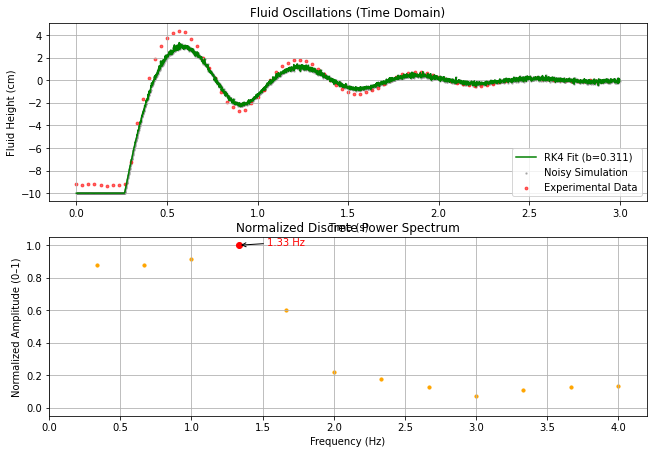

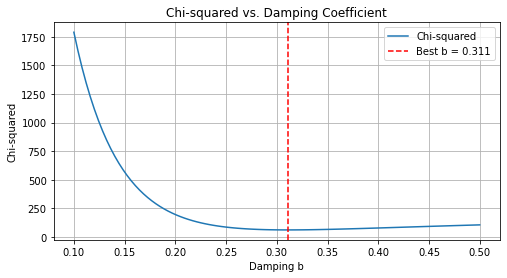

Simulation complete. Data and figures saved and displayed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.optimize import minimize_scalar
from scipy.signal import resample
import pandas as pd

# ---------------------------
# Load Data
# ---------------------------
data = pd.read_csv("/home/ad.csueastbay.edu/ye4908/gravity-straw-project/data/full_displacement_data_cm.csv")
t_exp = data["t"].values
y_exp = data["y"].values
n_samples_exp = len(y_exp)

# ---------------------------
# Constants for the Physical System and Simulation
# ---------------------------

g = 9.81
h = 0.102
z0 = 0.002
vz0 = 0.0
t_max = 3.0
dt = 0.001
n_steps = int(t_max / dt)
burn_in = 266

# ---------------------------
# Acceleration: 
# Reflects physical model discussed in
# Gravity-driven fluid oscillations in a drinking straw
# Ryan P. Smith, and Eric H. Matlis
# ---------------------------

def acceleration(z, vz, g, h, b):
    y = max(z, 0.002)
    az = -1 / y * (vz**2 + g * y - g * h + b * vz)
    return az

# ---------------------------
# rk4_solver: numerically integrates the motion using RK4 method
# ---------------------------

def rk4_solver(z0, vz0, g, h, b, dt, n_steps, noise=True):
    # Initialize arrays for position, velocity, and time
    z = np.zeros(n_steps)
    vz = np.zeros(n_steps)
    t = np.zeros(n_steps)

    # Set initial conditions
    z[0], vz[0] = z0, vz0

    # Burn-in phase: constant displacement z0 for initialization
    for i in range(1, burn_in):
        z[i] = z0
        t[i] = t[i-1] + dt

    # RK4 time-stepping loop begins after burn-in
    for i in range(burn_in, n_steps):
        z_i = max(z[i-1], 0.002)  # Avoid division by zero in acceleration

        # Compute RK4 terms
        k1z = vz[i-1]
        k1v = acceleration(z_i, vz[i-1], g, h, b)

        z_k2 = max(z[i-1] + 0.5 * dt * k1z, 1e-6)
        vz_k2 = vz[i-1] + 0.5 * dt * k1v
        k2z = vz_k2
        k2v = acceleration(z_k2, vz_k2, g, h, b)

        z_k3 = max(z[i-1] + 0.5 * dt * k2z, 1e-6)
        vz_k3 = vz[i-1] + 0.5 * dt * k2v
        k3z = vz_k3
        k3v = acceleration(z_k3, vz_k3, g, h, b)

        z_k4 = max(z[i-1] + dt * k3z, 1e-6)
        vz_k4 = vz[i-1] + dt * k3v
        k4z = vz_k4
        k4v = acceleration(z_k4, vz_k4, g, h, b)

        # Update position and velocity using weighted average of slopes
        z[i] = z[i-1] + (dt / 6.0) * (k1z + 2 * k2z + 2 * k3z + k4z)
        vz[i] = vz[i-1] + (dt / 6.0) * (k1v + 2 * k2v + 2 * k3v + k4v)
        t[i] = t[i-1] + dt

    # Add noise if enabled (simulates experimental error or randomness)
    if noise:
        noise_vals = np.random.normal(loc=0.0, scale=0.01 * np.abs(z), size=z.shape)
        z += noise_vals

    # Convert from meters to centimeters for consistency with experimental data
    z *= 100

    return t, z

# ---------------------------
# Chi-Squared Optimization of b: 
# fits b by minimizing chi-squared statistic between experimental and simulated data
# as the simulation is swept through a range of b parameters
# ---------------------------

def chi_squared(b_test, z_exp=y_exp):
    t_sim, z_sim = rk4_solver(z0, vz0, g, h, b_test, dt, n_steps, noise=False)
    z_resamp = resample(z_sim - h * 100, n_samples_exp)
    return np.sum(abs((z_resamp - z_exp)**2 / z_exp))

def optimize_b():
    result = minimize_scalar(chi_squared, bounds=(0.1, 0.5), method='bounded')
    return result.x

# ---------------------------
# Spectral analysis
# ---------------------------

def dft(x):  # Discrete Fourier Transform
    x = np.asarray(x, dtype=np.complex128)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    exponent = -2j * np.pi * k * n / N
    return np.dot(np.exp(exponent), x)

def spectrum_analysis(t, z, f_max=None):
    z_detrended = z - np.mean(z)
    fs = 1 / dt
    N = len(z_detrended)

    dft_vals = dft(z_detrended)
    freqs = np.fft.fftfreq(N, d=1/fs)

    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    amplitudes = np.abs(dft_vals[pos_mask]) * 2 / N

    if np.max(amplitudes) > 0:
        amplitudes = amplitudes / np.max(amplitudes)

    if f_max is not None:
        cut_mask = freqs <= f_max
        freqs_cut = freqs[cut_mask]
        amps_cut = amplitudes[cut_mask]
    else:
        freqs_cut = freqs
        amps_cut = amplitudes

    return freqs_cut, amps_cut

# ---------------------------
# Run Once and Save/Display Outputs
# ---------------------------

# Optimize b and simulate once
b_best = optimize_b()
t_sim, z_sim = rk4_solver(z0, vz0, g, h, b_best, dt, n_steps, noise=True)
z_sim_disp = z_sim - h * 100
freqs, amplitudes = spectrum_analysis(t_sim, z_sim_disp)

# Save time-domain simulation data
pd.DataFrame({
    "t": t_sim,
    "z_cm": z_sim_disp
}).to_csv("simulated_fluid_displacement_with_noise.csv", index=False)

# Save frequency-domain (spectrum) data
pd.DataFrame({
    "frequency_Hz": freqs,
    "normalized_amplitude": amplitudes
}).to_csv("simulated_power_spectrum_with_noise.csv", index=False)

# Plot and save simulation + spectrum
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

axs[0].scatter(t_sim, z_sim_disp, s=2, color='gray', alpha=0.5, label='Noisy Simulation')
axs[0].plot(t_sim, z_sim_disp, color='green', label=f'RK4 Fit (b={b_best:.3f})')
axs[0].scatter(t_exp, y_exp, s=8, color='red', alpha=0.6, label='Experimental Data')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Fluid Height (cm)")
axs[0].set_title("Fluid Oscillations (Time Domain)")
axs[0].legend()
axs[0].grid(True)

peak_idx = np.argmax(amplitudes)
peak_freq = freqs[peak_idx]
peak_amp = amplitudes[peak_idx]
f_max = max(3 * peak_freq, 2.0)

axs[1].scatter(freqs, amplitudes, color='orange', s=10)
axs[1].plot(peak_freq, peak_amp, 'ro')
axs[1].annotate(f"{peak_freq:.2f} Hz",
                xy=(peak_freq, peak_amp),
                xytext=(peak_freq + 0.2, peak_amp),
                arrowprops=dict(arrowstyle="->"),
                fontsize=10,
                color='red')
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Amplitude (0–1)")
axs[1].set_xlim(left=0, right=f_max * 1.05)
axs[1].set_title("Normalized Discrete Power Spectrum")
axs[1].grid(True)

fig.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.12)
fig.savefig("simulation_and_spectrum_plots.png", dpi=300)
plt.show()

# Save chi-squared curve
b_range = np.linspace(0.1, 0.5, 100)
chi_vals = [chi_squared(b) for b in b_range]

plt.figure(figsize=(8, 4))
plt.plot(b_range, chi_vals, label="Chi-squared")
plt.axvline(b_best, color='red', linestyle='--', label=f"Best b = {b_best:.3f}")
plt.xlabel("Damping b")
plt.ylabel("Chi-squared")
plt.title("Chi-squared vs. Damping Coefficient")
plt.legend()
plt.grid(True)
plt.savefig("chi_squared_vs_b.png", dpi=300)
plt.show()

print("Simulation complete. Data and figures saved and displayed.")
